# MVP 2: Object-Centric Stream Mining

The following .ipnb concludes MVP 2, that facilitates Object-Centric Stream mining.
The goal is to demonstrate the newly acquired capabilities of the **PyBeamline** library in processing and analyzing event data streams in an object-centric manner.

### Object-Centric Mining Operator

The object-centric mining operator `oc_operator` is a new key component of the **PyBeamline** library, designed to handle object-centric event data. It transforms a stream of complex events (e.g., **BOEvents**) into a series of object-type-specific views. These views are used to incrementally construct control-flow models, such as Directly-Follows Graphs (DFGs), for each object type in the stream.

This modular approach allows the user to define per-object-type control flow discovery algorithms — offering high flexibility in how process models evolve over time. This is particularly useful in scenarios where different object types may have distinct characteristics or behaviors, requiring tailored mining strategies, thus resulting in a more accurate and meaningful representation of the underlying processes.

If no control flow is provided, the operator will default to *dynamic mode* using the `heuristics_miner_lossy_counting` algorithm, and assign it to each object type registered throughout the stream. This ensures that even if no specific algorithm is defined, the operator can still function effectively, and one can do dynamic discovery of objects

### Lossy Counting Integration

To support streaming, **PyBeamline** integrates Lossy Counting for frequency approximation. This ensures memory-efficient updates while maintaining a bounded error rate.
The algorithms of `heuristics_miner_lossy_counting` and `heuristics_miner_lossy_counting_budget` have been wrapped to support **BOEvents** (aka. OCPM). In combination with `oc_operator` each object type, event frequencies are tracked in buckets, and infrequent elements are purged periodically to guarantee scalability in long-running streams.

### OCDFG Merge Operator

To support a global view across object types, the `ocdfg_merge_operator` incrementally combines and updates individual object-type models into a unified **Object-Centric Directly-Follows Graph (OCDFG)**. This model of `OCDFG` is based on the reference paper: *Berti, Alessandro, and Wil van der Aalst. "Extracting multiple viewpoint models from relational databases." Data-Driven Process Discovery and Analysis. Springer, Cham, 2018. 24-51.* though accommodated to the realm of streaming without having an entire object-centric event log in memory.

The OCDFG:
- Tracks activities and transitions per object type
- Preserves start and end activities
- Ensures that guarantees provided by algorithms such as `heuristics_miner_lossy_counting` (e.g., **frequency approximations** and **error bounds**) are maintained locally within each object type.


### Example of Usage

The following example demonstrates how the `oc_operator` can be given object-type specific streaming miners. Then from the output of each of the obj-type streams the `oc_merge_operator` will be orchastratic the merge aspect of the different DFG's. In the example notice how causality flow of the **test_events_phaseflow_ends_early** lost due to lossy counting algorithm.


In [1]:
# Loading the required libraries
import importlib
import pybeamline  # replace with your module name
from pybeamline.objects.ocdfg import OCDFG

importlib.reload(pybeamline)
from pybeamline.algorithms.discovery import heuristics_miner_lossy_counting, heuristics_miner_lossy_counting_budget
from pybeamline.sources.dict_ocel_test_source import dict_test_ocel_source
from pybeamline.sources.ocel_log_source_from_file import ocel_log_source_from_file
from pybeamline.algorithms.oc.oc_operator import oc_operator
from pybeamline.algorithms.oc.oc_merge_operator import ocdfg_merge_operator
from reactivex import operators as ops
from pybeamline.utils.visualizer import Visualizer
from IPython.display import display


In [2]:
test_events_phaseflow = [
    {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
    {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
    {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
    {"activity": "Reserve Item", "objects": {"Item": ["i1"]}},
    {"activity": "Pack Item", "objects": {"Item": ["i1"], "Order": ["o1"]}},
    {"activity": "Ship Item", "objects": {"Item": ["i1"], "Shipment": ["s1"]}},
    {"activity": "Send Invoice", "objects": {"Order": ["o1"], "Invoice": ["inv1"]}},
    {"activity": "Receive Review", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
]

test_events_phaseflow_ends_early = [
    {"activity": "Register Customer", "objects": {"Customer": ["c2"]}},
    {"activity": "Create Order", "objects": {"Customer": ["c2"], "Order": ["o2"]}},
    {"activity": "Add Item", "objects": {"Order": ["o2"], "Item": ["i2"]}},
    {"activity": "Reserve Item", "objects": {"Item": ["i2"]}},
    {"activity": "Cancel Order", "objects": {"Customer": ["c2"], "Order": ["o2"]}}
]

combined_log = dict_test_ocel_source([(test_events_phaseflow_ends_early,25),(test_events_phaseflow, 250)], shuffle=False)



In [3]:
# Supplied control flow, allowing for specified algorithms for each object type
# if one object type is not specified, then the resulting OCDFG will not represent that object type. This is similar to Projection
control_flow = {
    "Order": heuristics_miner_lossy_counting(model_update_frequency=10, max_approx_error=0.1),
    "Item": heuristics_miner_lossy_counting_budget(model_update_frequency=10),
    "Customer": heuristics_miner_lossy_counting(model_update_frequency=10, max_approx_error=0.1),
    "Shipment": heuristics_miner_lossy_counting(model_update_frequency=10),
    "Invoice": heuristics_miner_lossy_counting(model_update_frequency=10),
}

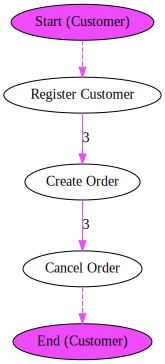

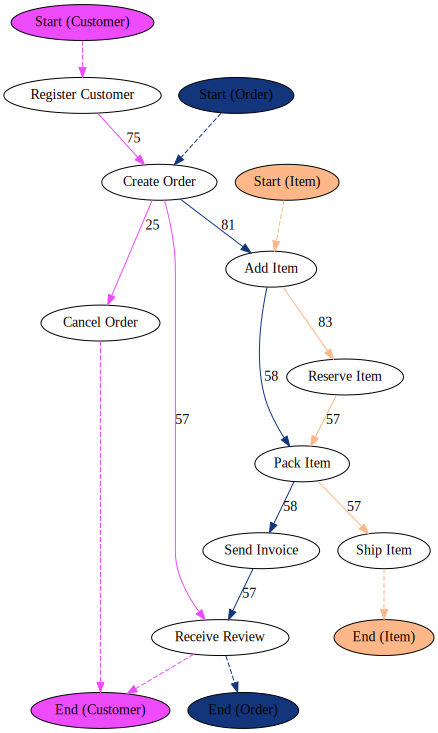

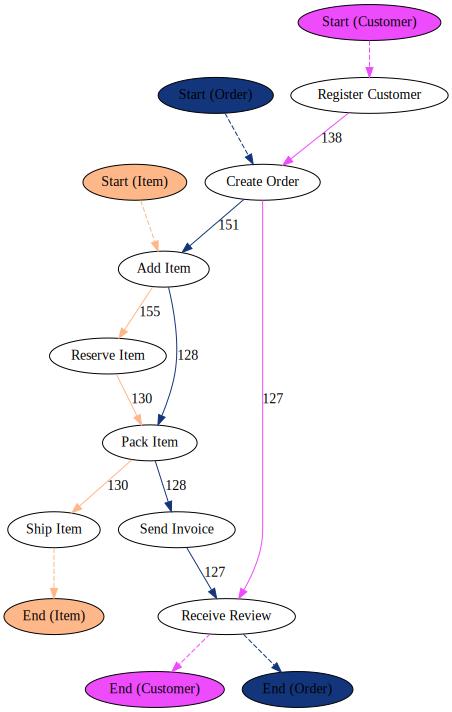

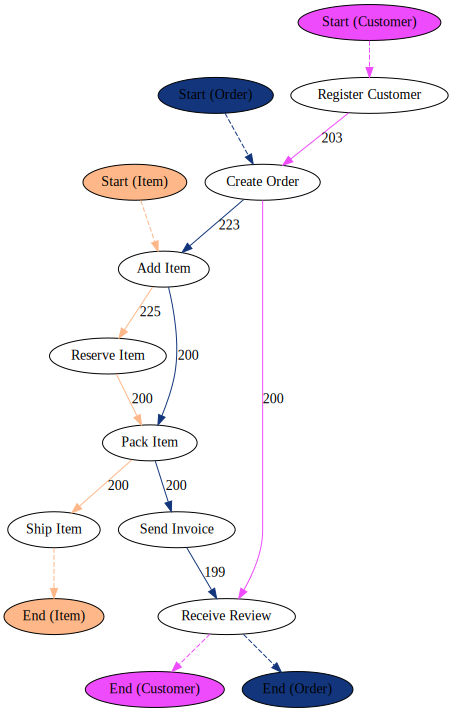

In [4]:
ocdfgs = []
def append_ocdfg(ocdfg):
    global ocdfgs
    ocdfgs.append(ocdfg)


# Object-Centric Operators
combined_log.pipe(
    oc_operator(control_flow),
    ocdfg_merge_operator(),
).subscribe(lambda ocdfg: append_ocdfg(ocdfg))

# visualize the OCDFG
visualizer = Visualizer()

i = 0
for i in range(len(ocdfgs)):
    if i % 100 == 0:
        display(visualizer.draw_ocdfg(ocdfgs[i]))
    i += 1


Throughout the rendered output notice how the activity of **"Cancel Order"** is forgotten.

## Example of Dynamic Mode

Dynamic mode of the `oc_operator` is when the object types of the system is unknown and knowledge regarding the object-types and their *directly-follows flow* are wanted.
Throughot this example, the stream considered is based on the OCEL 2.0 object-centric event log of Logistics. Can be found here:
https://www.ocel-standard.org/event-logs/simulations/logistics/

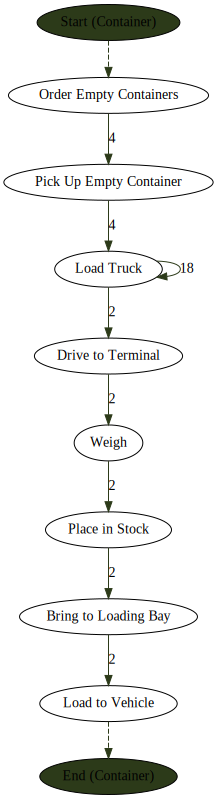

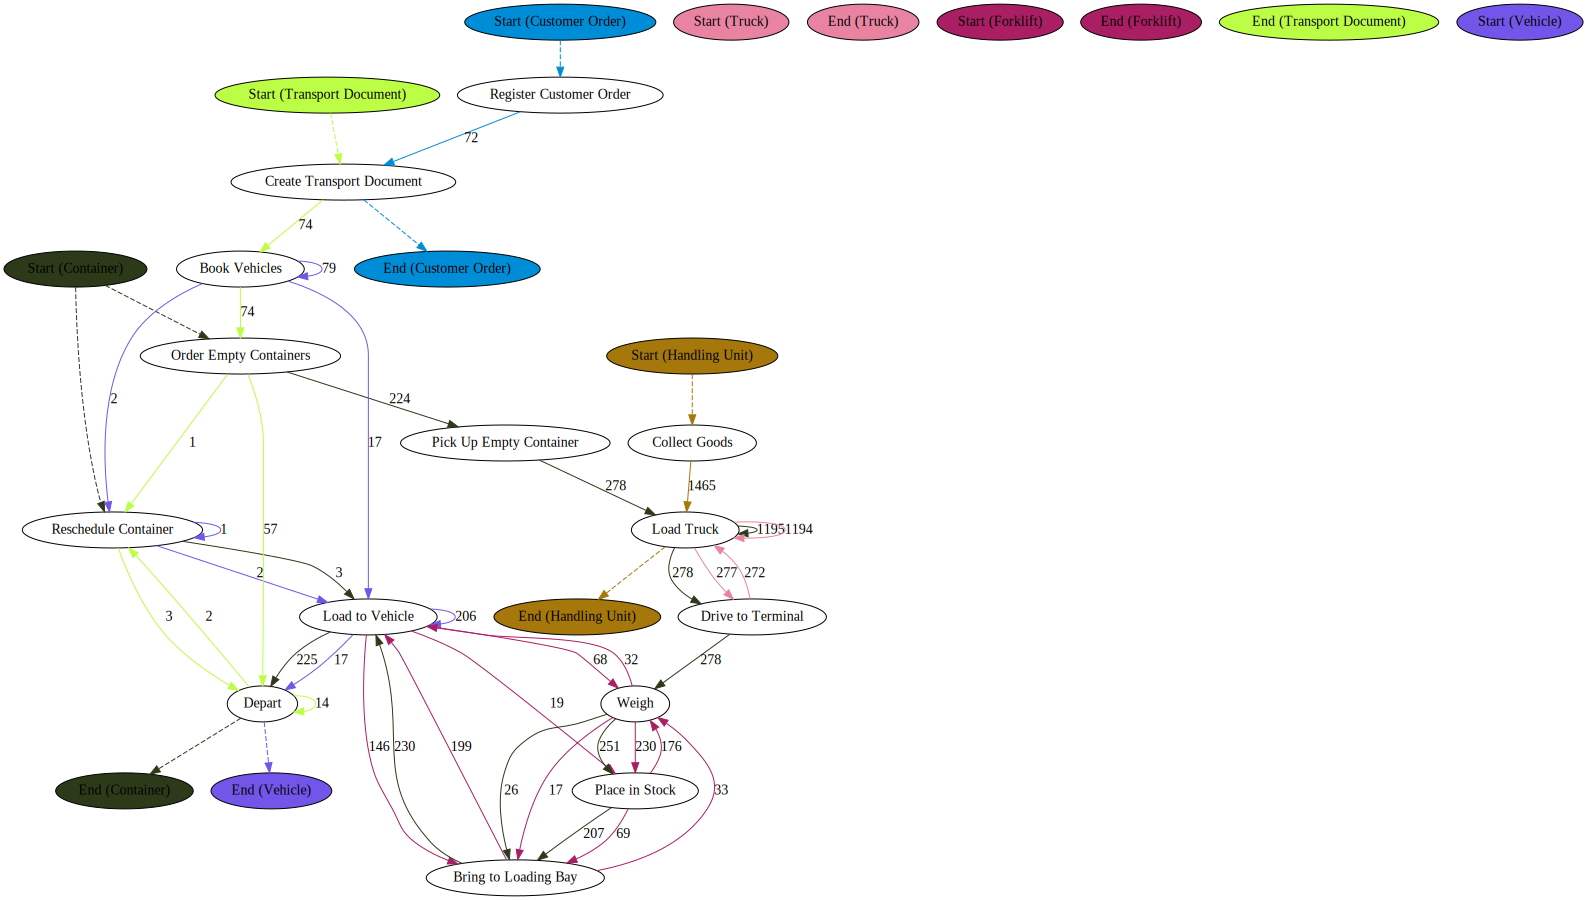

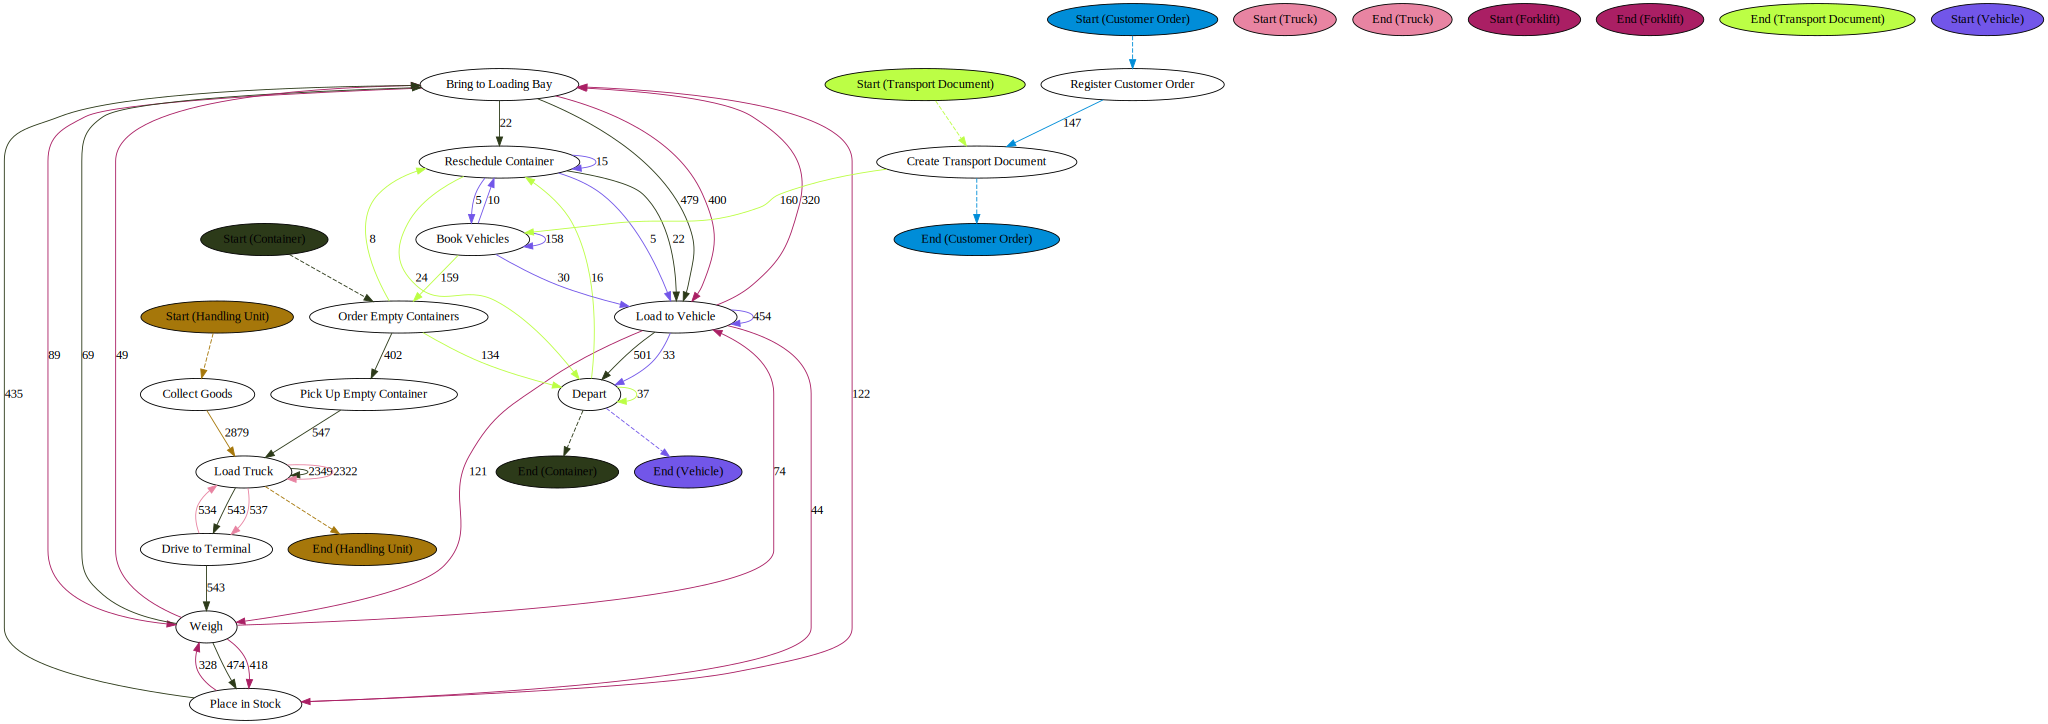

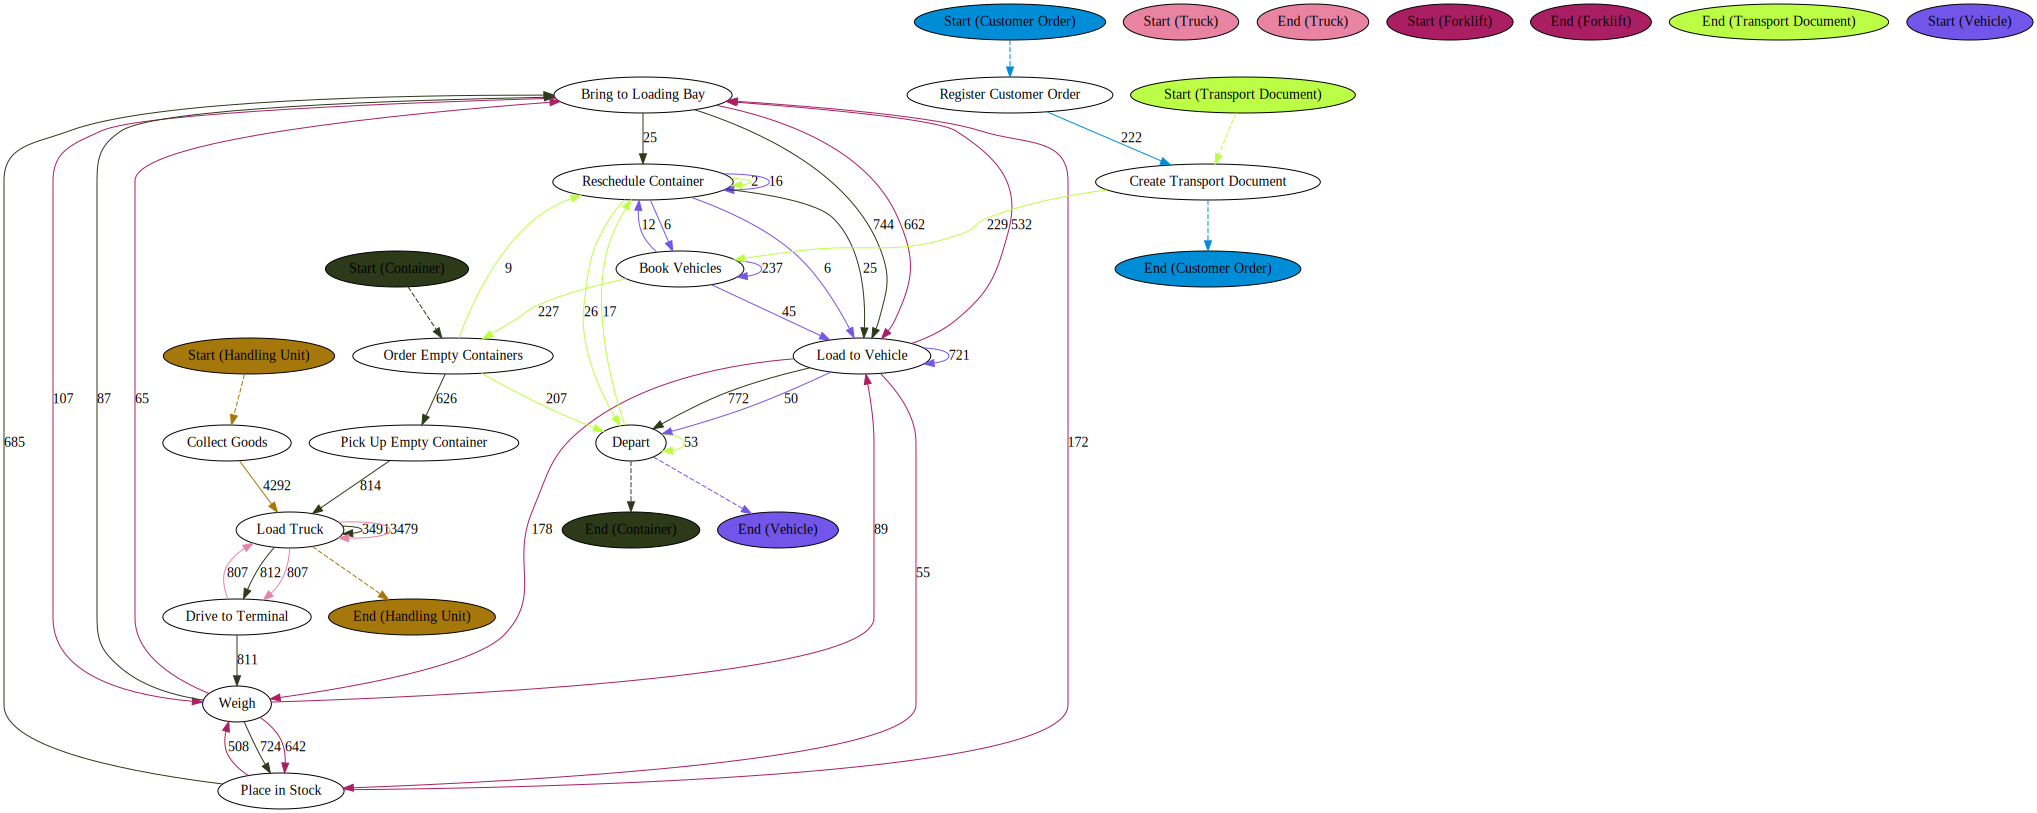

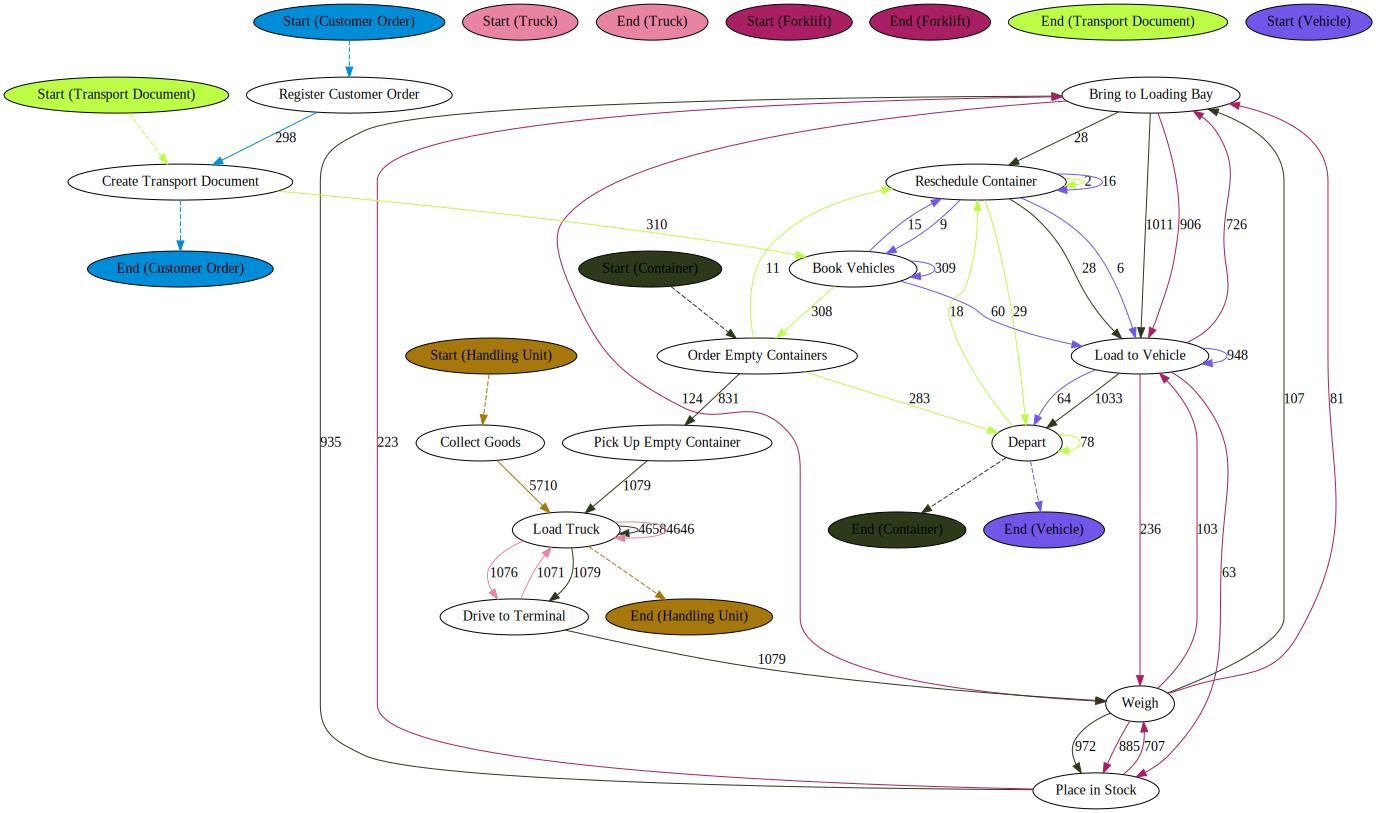

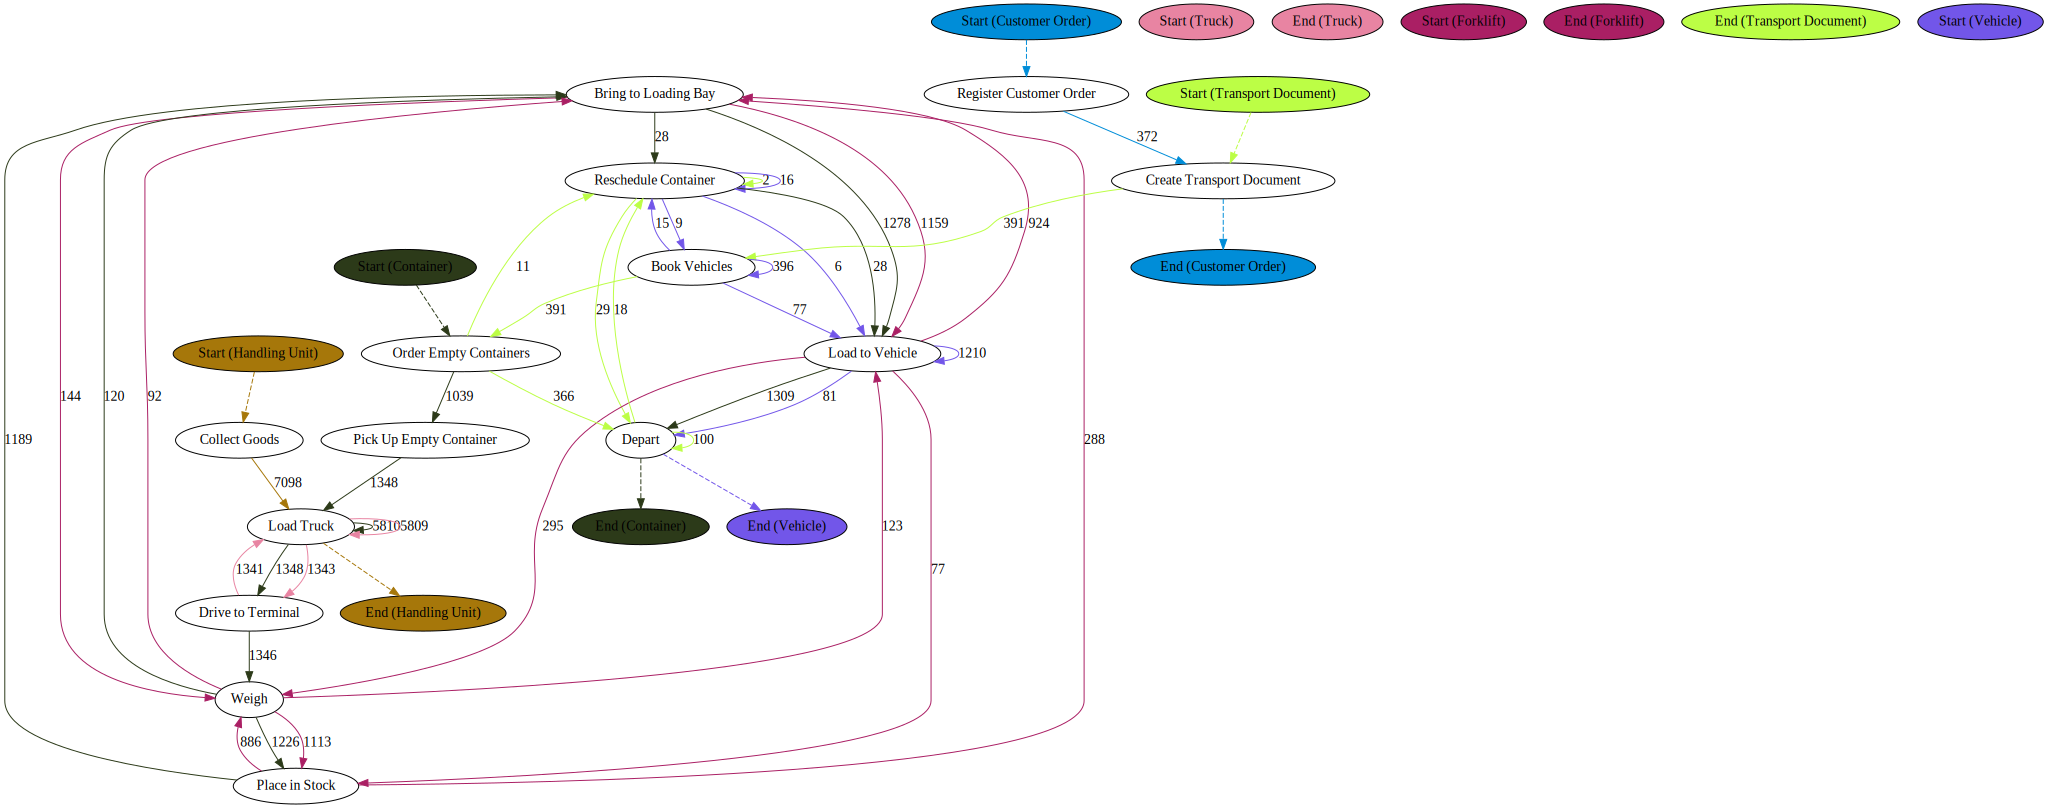

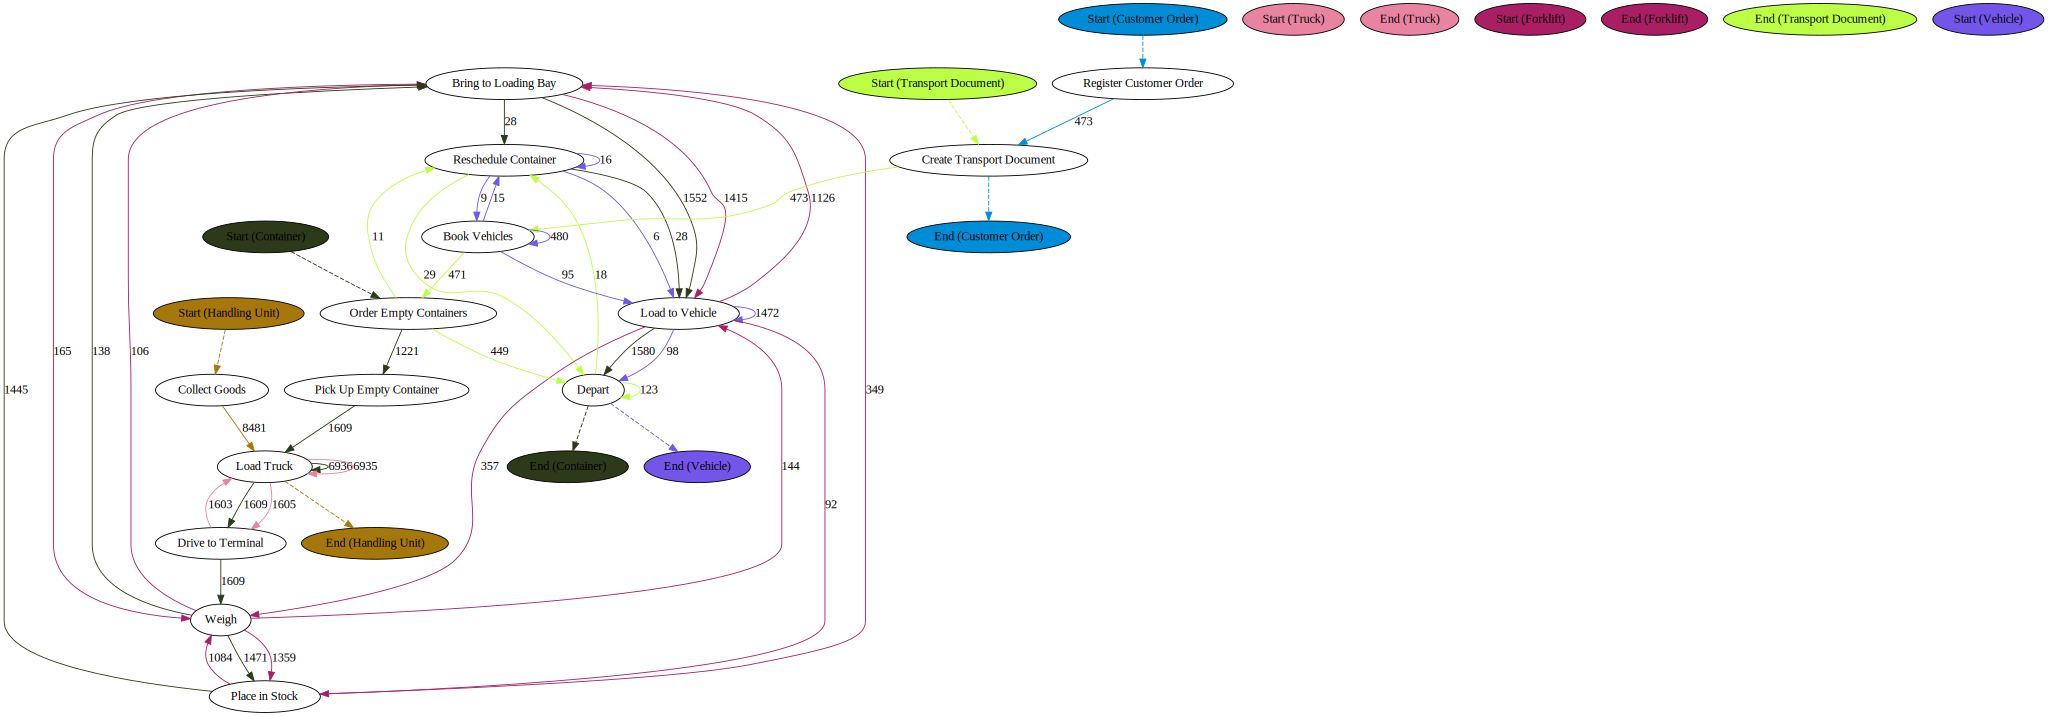

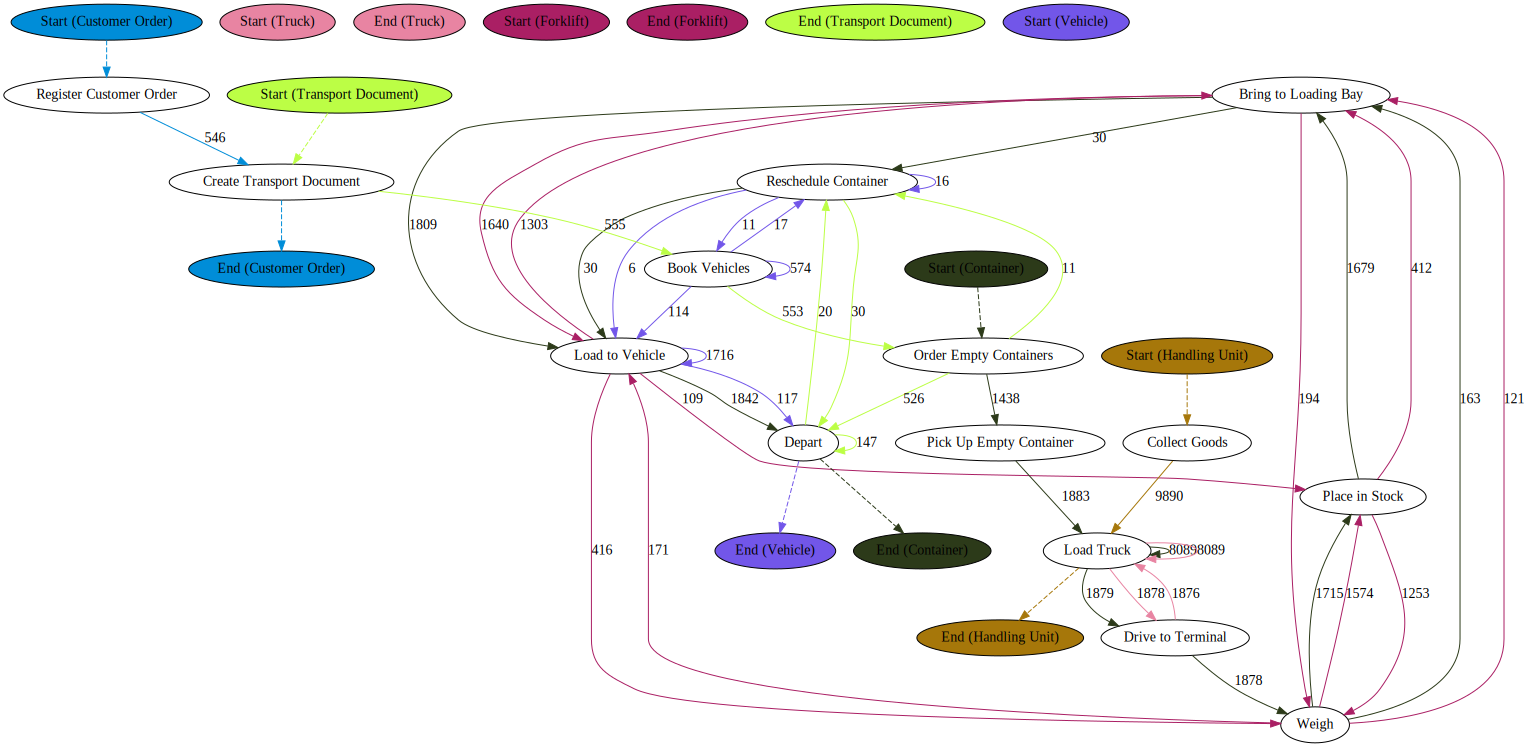

In [5]:
unknown_stream = ocel_log_source_from_file("../../tests/logistics.jsonocel")

ocdfgs = []
def append_ocdfg(ocdfg):
    global ocdfgs
    ocdfgs.append(ocdfg)

unknown_stream.pipe(
    oc_operator(),
    ocdfg_merge_operator()
).subscribe(lambda ocdfg: append_ocdfg(ocdfg))

j = 0
for j in range(len(ocdfgs)):
    if j % 200 == 0:
        display(visualizer.draw_ocdfg(ocdfgs[j]))
    j += 1


Once a sufficient view or knowledge the of the stream is discovered—along with the corresponding object types—it opens up several opportunities for refinement and exploration.
With knowledge of the involved object types, you can:
- Redefine the control flow mapping: selectively include or exclude certain object types from the analysis.
- Inject domain knowledge manually: such as tuning the **max_approx_error** parameter per object type, based on your understanding of process variability or data importance.
- Iteratively re-run oc_operator with a refined control flow configuration to focus on specific object-centric perspectives.
- Experiment with different streaming mining algorithms (e.g., variants of Heuristics Miner, adaptive filters), optimizing per object type.

This flexible design allows blending conventional object-centric discovery with non-traditional or domain-specific constraints, resulting in a more tailored and insightful process model.

###

## Limitations

While MVP 2 successfully introduces object-centric stream mining using it comes with a few important limitations:

- Forgetting is Localized: The lossy counting mechanism—used to approximate frequencies and control memory usage—is applied independently within each object type stream. This means that rare activities (e.g., "Cancel Order") may be forgotten if they fall below the support threshold, but only within the context of that object type. The global impact of such events across types is not captured.

- Object types are never forgotten: The current implementation does not support forgetting entire object types. Once an object type is registered, it remains in the system, even if it becomes inactive or irrelevant. This could lead to memory bloat and inefficiencies in processing.

- Cross-Type Activity Semantics Are Not Preserved: Since merging across object types is driven by shared activity labels, lossy counting may cause inconsistencies in how transitions are reflected across types. For example, an activity that is forgotten in one object type may still appear in another, leading to incomplete or misleading global models.

- No Global Memory Budget: The current implementation applies error bounds per object type, without a unified global constraint on memory usage or complexity. This could lead to scalability issues in high-cardinality logs with many distinct object types.

- Static Merge Criteria: The OCDFG merging strategy relies on naive activity matching. More dynamic criteria—such as semantic similarity or temporal correlation—are not yet considered.

### Example of limitation
The following example demonstrates the limitation of *object types never being forgotten*.


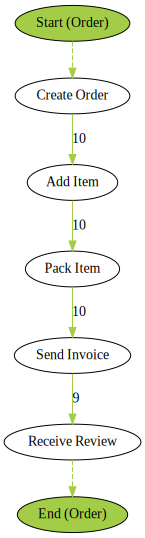

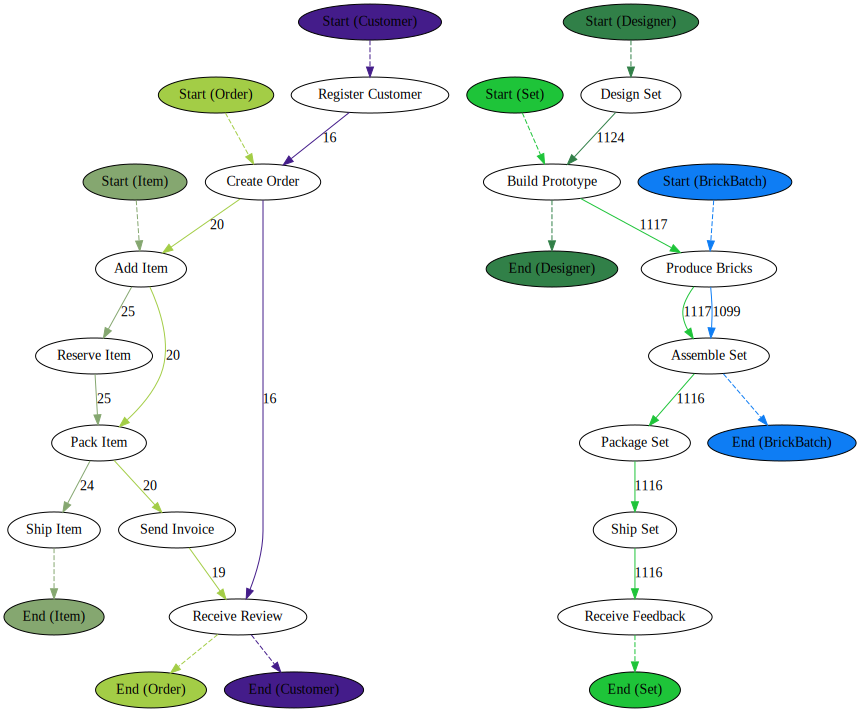

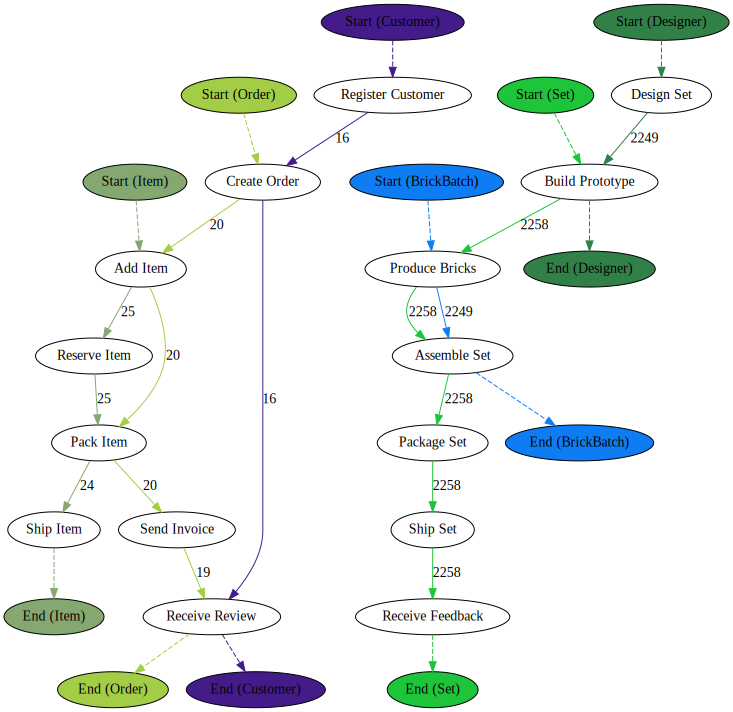

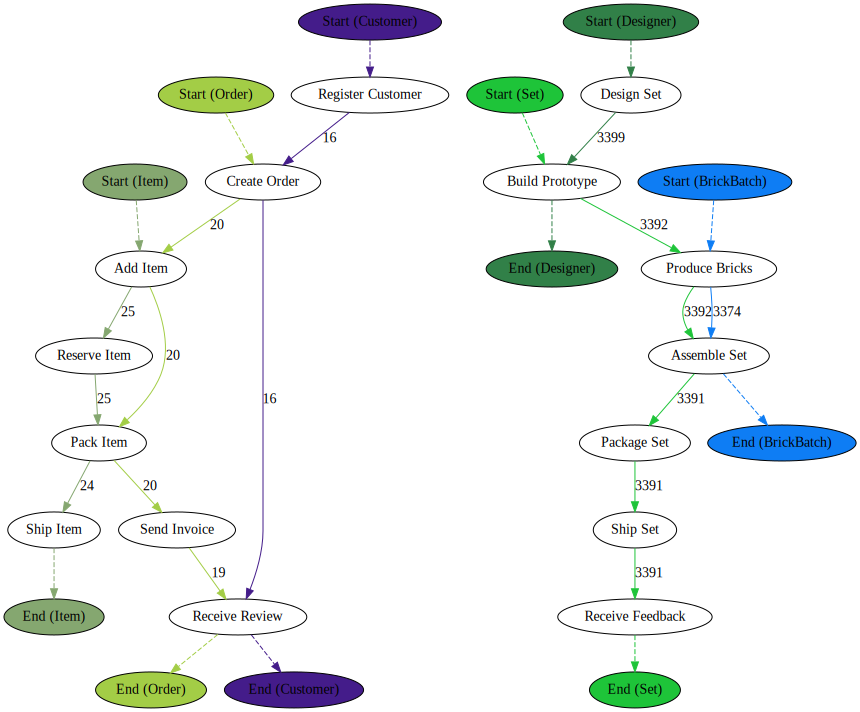

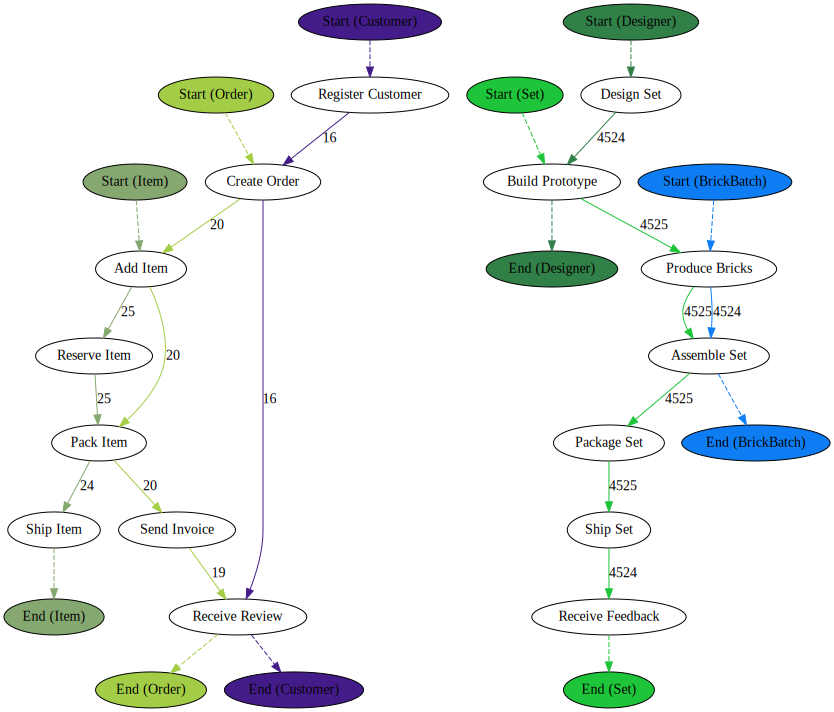

In [11]:
test_events_phaseflow = [
    {"activity": "Register Customer", "objects": {"Customer": ["c1"]}},
    {"activity": "Create Order", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
    {"activity": "Add Item", "objects": {"Order": ["o1"], "Item": ["i1"]}},
    {"activity": "Reserve Item", "objects": {"Item": ["i1"]}},
    {"activity": "Pack Item", "objects": {"Item": ["i1"], "Order": ["o1"]}},
    {"activity": "Ship Item", "objects": {"Item": ["i1"], "Shipment": ["s1"]}},
    {"activity": "Send Invoice", "objects": {"Order": ["o1"], "Invoice": ["inv1"]}},
    {"activity": "Receive Review", "objects": {"Customer": ["c1"], "Order": ["o1"]}},
]

test_events_lego_phaseflow_simple = [
    {"activity": "Design Set", "objects": {"Designer": ["d1"]}},
    {"activity": "Build Prototype", "objects": {"Designer": ["d1"], "Set": ["s1"]}},
    {"activity": "Produce Bricks", "objects": {"Set": ["s1"], "BrickBatch": ["bb1"]}},
    {"activity": "Assemble Set", "objects": {"Set": ["s1"], "BrickBatch": ["bb1"]}},
    {"activity": "Package Set", "objects": {"Set": ["s1"]}},
    {"activity": "Ship Set", "objects": {"Set": ["s1"], "Shipment": ["sh1"]}},
    {"activity": "Receive Feedback", "objects": {"Set": ["s1"]}},
]

log = dict_test_ocel_source([(test_events_phaseflow, 25), (test_events_lego_phaseflow_simple, 5000)], shuffle=False)

ocdfgs = []
def append_ocdfg(ocdfg):
    global ocdfgs
    ocdfgs.append(ocdfg)

log.pipe(
    #ops.do_action(lambda e: print(e)),
    oc_operator(), # In dynamic mode
    ocdfg_merge_operator()
).subscribe(lambda ocdfg: append_ocdfg(ocdfg))

# visualize the OCDFG
visualizer = Visualizer()

i = 0
for i in range(len(ocdfgs)):
    if i % 250 == 0:
        display(visualizer.draw_ocdfg(ocdfgs[i]))
    i += 1
